# <a id='toc1_'></a>[Notebook de modelisation simple](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Notebook de modelisation simple](#toc1_)    
  - [Extraction des données](#toc1_1_)    
  - [Lecture du dataframe](#toc1_2_)    
  - [Preprocessing](#toc1_3_)    
    - [Target columns](#toc1_3_1_)    
    - [Text preprocessing](#toc1_3_2_)    
    - [Word cloud](#toc1_3_3_)    
- [Comparatif des vectorizer](#toc2_)    
- [Entrainement modèle simple (logistic regression)](#toc3_)    
- [Entrainement modèle sur-mesure avancé (BERT)](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
!pip install uv
!uv pip install pandas numpy matplotlib scikit-learn wordcloud tqdm sentence_transformers ipykernel tensorflow

Using Python 3.11.12 environment at: /usr
Audited 9 packages in 116ms


In [ ]:
import os
import re
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from wordcloud import WordCloud

tqdm.pandas()

import string
import warnings

warnings.filterwarnings("ignore")
import tensorflow as tf
from sentence_transformers import SentenceTransformer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
import torch

## <a id='toc1_1_'></a>[Extraction des données](#toc0_)

In [ ]:
# Extraction des données
ZIP_PATH = '/content/drive/MyDrive/Openclassrooms/Projet 7/data/sentiment140.zip'
DATA_PATH = '/content/drive/MyDrive/Openclassrooms/Projet 7/data'

# Verifier l'existance des data et extraire le zip dedans
if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_PATH)
    print("Fichiers extraits avec succès dans :", DATA_PATH)
else:
    print('Folder existant !')

print(f'Liste des dossier et fichier disponible {os.listdir(DATA_PATH)}')

Fichiers extraits avec succès dans : /content/drive/MyDrive/Openclassrooms/Projet 7/data
Liste des dossier et fichier disponible ['sentiment140.zip', 'training.1600000.processed.noemoticon.csv']


## <a id='toc1_2_'></a>[Lecture du dataframe](#toc0_)

In [ ]:
DATASET_PATH = os.path.join(DATA_PATH, 'training.1600000.processed.noemoticon.csv')
df = pd.read_csv(DATASET_PATH, sep=',', encoding = "ISO-8859-1", header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## <a id='toc1_3_'></a>[Preprocessing](#toc0_)
Renommer les colonnes en ce basant sur les cards du [dataset kaggle](https://www.kaggle.com/datasets/kazanova/sentiment140)

In [ ]:
# Renommer les colonnes en ce basant sur les cards du dataset
df = df.rename(columns={
    df.columns[0]: 'target',
    df.columns[1]: 'ids',
    df.columns[2]: 'date',
    df.columns[3]: 'flag',
    df.columns[4]: 'user',
    df.columns[5]: 'text',

})

complete_df = df[['target', 'text']]
useful_df = df[['target', 'text']].sample(10_000)

### <a id='toc1_3_1_'></a>[Target columns](#toc0_)

In [ ]:
# Afficher la valeurs des labels initiaux
print(useful_df['target'].value_counts())

# Conversion en binaire 0,1
useful_df['target'] = useful_df['target'].replace({0: 0, 4: 1})

# Affichage des données corrigé
print(useful_df['target'].value_counts())

target
0    5018
4    4982
Name: count, dtype: int64
target
0    5018
1    4982
Name: count, dtype: int64


### <a id='toc1_3_2_'></a>[Text preprocessing](#toc0_)

In [ ]:

def tweet_cleaning(tweet):
    """
    Nettoie et prétraite un tweet pour une analyse de sentiment.

    Cette fonction effectue plusieurs étapes de nettoyage :
        - Suppression des URLs, mentions et hashtags
        - Suppression des emojis et caractères spéciaux
        - Suppression de la ponctuation et des chiffres
        - Normalisation du texte (minuscules, espaces multiples)

    Params :
        tweet (str) : Le tweet brut à nettoyer.

    Return :
        str : Le tweet nettoyé et prétraité, prêt pour l'analyse de sentiment.

    """
    # Supprimer les URLs
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)

    # Supprimer les mentions (@user)
    tweet = re.sub(r'@\w+', '', tweet)

    # Supprimer les hashtags (#hashtag)
    tweet = re.sub(r'#\w+', '', tweet)

    # Normaliser & supprimer les caractères
    tweet = tweet.encode('ascii', 'ignore').decode('utf-8')
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)

    # Supprimer la ponctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Supprimer les chiffres
    tweet = re.sub(r'\d+', '', tweet)

    # Supprimer les espaces multiples et les espaces au début/fin
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet



In [ ]:
useful_df['text'] = useful_df['text'].progress_apply(tweet_cleaning)

100%|██████████| 10000/10000 [00:00<00:00, 17393.07it/s]


### <a id='toc1_3_3_'></a>[Word cloud](#toc0_)

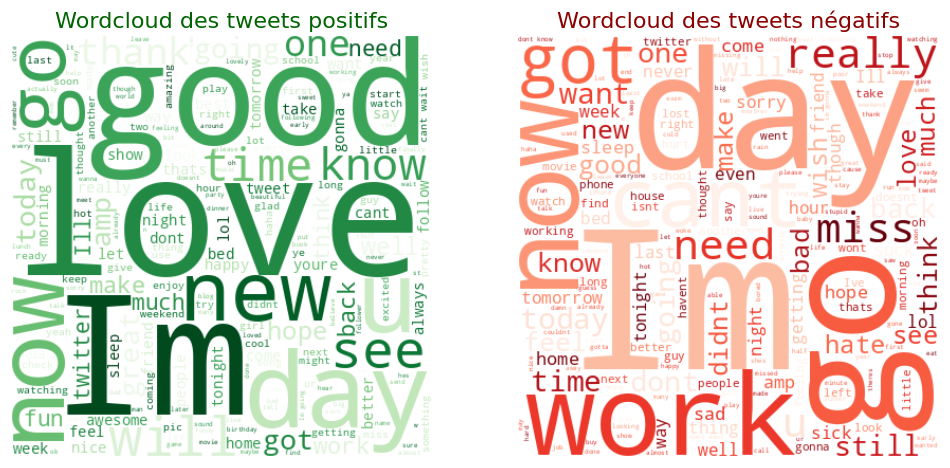

In [ ]:
# Definir le vectorizer
vectorizer = TfidfVectorizer()

# Appliquer la vectorization
X_text = vectorizer.fit_transform(useful_df["text"]).toarray()

# Definir les texts positifs et negatifs
positive_text = "".join(useful_df[useful_df['target'] == 1]['text'])
negative_text = "".join(useful_df[useful_df['target'] == 0]['text'])

plt.figure(figsize=(12,6))
# Wordcloud positif
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=400, height=400, background_color='white', colormap='Greens').generate(positive_text)
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis('off')
plt.title('Wordcloud des tweets positifs', fontsize=16, color="darkgreen")

# Wordcloud negatif
plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=400, height=400, background_color='white', colormap='Reds').generate(negative_text)
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis('off')
plt.title('Wordcloud des tweets négatifs', fontsize=16, color="darkred")

plt.show()

# <a id='toc2_'></a>[Comparatif des vectorizer](#toc0_)

In [ ]:
X = useful_df['text']
y = useful_df['target']

In [ ]:
def evaluate_model(X, y, vectorizer, model_name, is_sentence_transformer=False):
    """
    Entraîne et évalue un modèle de régression logistique à l'aide du vectorizer donné.

    Args:
        vectorizer (object): Vectorizer utilisé pour transformer les données.
        model_name (str): Nom du modèle/vectorizer pour les résultats.
        is_sentence_transformer (bool): Si True, utilise encode() au lieu de fit_transform().

    Returns:
        dict: Dictionnaire contenant les métriques associées au modèle sous la forme {model_name: metrics}.
    """
    # Split des données
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if is_sentence_transformer:
        X_train_vec = vectorizer.encode(x_train, show_progress_bar=False)
        X_test_vec = vectorizer.encode(x_test, show_progress_bar=False)
    else:
        X_train_vec = vectorizer.fit_transform(x_train)
        X_test_vec = vectorizer.transform(x_test)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_vec, y_train)

    y_pred = model.predict(X_test_vec)
    report = classification_report(y_test, y_pred, output_dict=True)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }

    return {model_name: metrics}

In [ ]:
def compare_vectorizer(X, y):
    """
    Compare les performances de différents vectorizers (TF-IDF, CountVectorizer, Sentence-Transformers)
    en les utilisant pour entraîner un modèle de régression logistique sur un jeu de données texte.

    Affiche un graphique comparatif des métriques de performance et retourne les résultats sous forme de dictionnaire.

    Args:
        X (array): Données textuelles (features).
        y (array): Labels cibles.

    Returns:
        dict: Dictionnaire contenant les métriques ('accuracy', 'precision', 'recall', 'f1-score')
              pour chaque vectorizer sous la forme {model_name: metrics}.
    """

    # Évaluation des trois vectorizers
    tfidf_metrics = evaluate_model(X, y, TfidfVectorizer(), 'TF-IDF')
    count_metrics = evaluate_model(X, y, CountVectorizer(), 'Count')
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    sbert_metrics = evaluate_model(X, y, sbert_model, 'Sentence-transformers', is_sentence_transformer=True)

    all_metrics = {
        **tfidf_metrics,
        **count_metrics,
        **sbert_metrics
    }

    # Préparation des données pour le graphique
    metrics_names = ['accuracy', 'precision', 'recall', 'f1-score']
    x_indexes = np.arange(len(metrics_names))
    bar_width = 0.25

    tfidf_values = [all_metrics['TF-IDF'][m] for m in metrics_names]
    count_values = [all_metrics['Count'][m] for m in metrics_names]
    sbert_values = [all_metrics['Sentence-transformers'][m] for m in metrics_names]

    # Création du graphique
    plt.figure(figsize=(12, 6))
    bars1 = plt.bar(x_indexes - bar_width, tfidf_values, width=bar_width, label='TF-IDF Vectorizer', color='#4E79A7')
    bars2 = plt.bar(x_indexes, count_values, width=bar_width, label='Count Vectorizer', color='#F28E2B')
    bars3 = plt.bar(x_indexes + bar_width, sbert_values, width=bar_width, label='Sentence-transformers', color='#76448A')

    # Ajout des valeurs au-dessus des barres
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center', va='bottom', fontsize=9)

    plt.xticks(x_indexes, metrics_names)
    plt.ylabel("Score")
    plt.title("Comparaison des performances des vectorizers")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

    return all_metrics

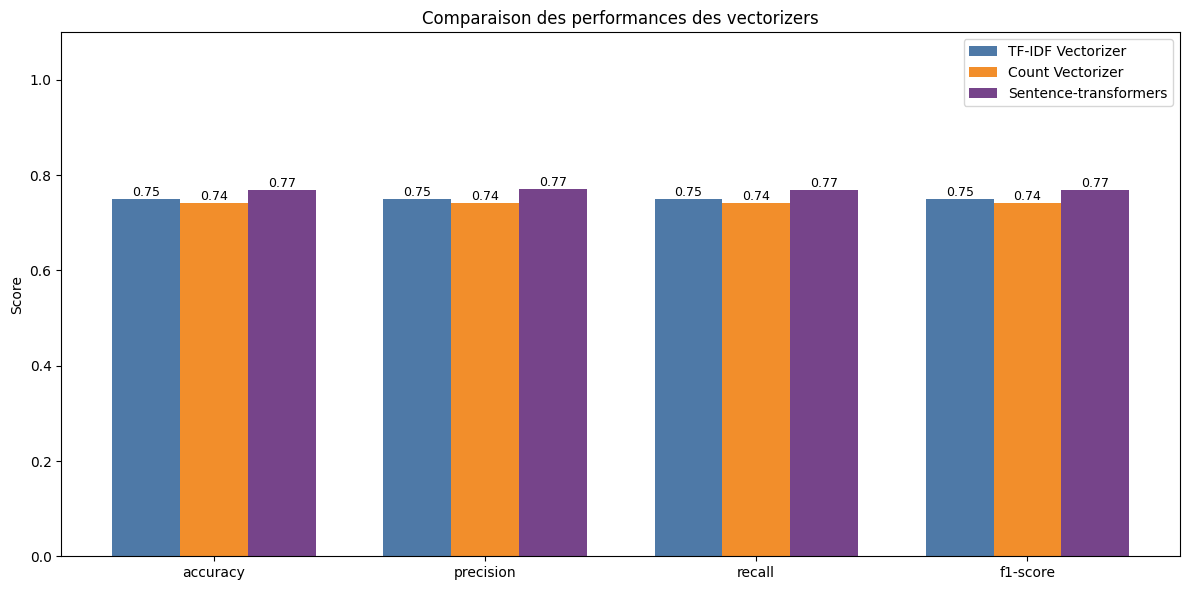

In [ ]:
data_vectorizers = compare_vectorizer(X.to_list(), y.to_list())

In [ ]:
# Afficher les resultat sous forme de dataframe
pd.DataFrame(data_vectorizers)

,TF-IDF,Count,Sentence-transformers
accuracy,0.751000,0.741000,0.770000
precision,0.750998,0.741203,0.770041
recall,0.751000,0.741000,0.770000
f1-score,0.750996,0.740976,0.770001


Sentence transformer a demontrer ici qu'il etait l'algorithme le plus performant sur nos données textuelles, nous allons donc pour la suite utiliser uniquement cet algo d'embedding, ces performance s'explique notament par le fait que sentence transformer crée ces embedding par rapport au contexte de la phrase

# <a id='toc3_'></a>[Entrainement modèle simple (logistic regression)](#toc0_)

In [ ]:
# Definir les parametres de la fonction evaluate_model
X = complete_df["text"]
y = complete_df["target"]
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Entrainement et evaluation du modèle
sbert_metrics =  evaluate_model(X, y, vectorizer, 'LogisticRegression', is_sentence_transformer=False)
print(sbert_metrics['LogisticRegression'])

{'accuracy': 0.801759375, 'precision': 0.8018498486710306, 'recall': 0.801759375, 'f1-score': 0.8017368647240635}


# <a id='toc4_'></a>[Entrainement modèle sur-mesure avancé (BERT)](#toc0_)

model card [here !](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)

Le modèle **nlptown/bert-base-multilingual-uncased-sentiment**  est une version de BERT multilingue fine-tunée pour l'analyse de sentiment.


Il prend en entrée du texte brut (en plusieurs langues) et produit en sortie une classification de sentiment discrète (généralement 1 à 5 étoiles).

In [ ]:
# Load le tokenizer et le model
tokenizer =  AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [ ]:
# Tester le tokenizer
tokens = tokenizer.encode("J'adore ce produit, il est vraiment top ! ", return_tensors='pt')
print("Encoded sentence: ", tokens)
print("Decoded sentence: ", tokenizer.decode(tokens[0]))

Encoded sentence:  tensor([[  101,   152, 39098, 10247, 10630, 21275,   117, 10145, 10182, 95370,
         11397,   106,   102]])
Decoded sentence:  [CLS] j adore ce produit, il est vraiment top! [SEP]


In [ ]:
# Tester le model
result = model(tokens)
print("raw result: ", result, "\n\n")
print("prediction:", int(torch.argmax(result.logits)) + 1)

raw result:  SequenceClassifierOutput(loss=None, logits=tensor([[-2.6638, -2.9276, -0.4553,  1.6668,  3.5053]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None) 


prediction: 5
